## Решающие деревья

In [755]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def Gini(R):
    ps = np.unique(R, return_counts=True)[1] / len(R)
    res = 0
    for p in ps:
        res += p * (1 - p)
    return res


def Q(Rm, j, t, H, feature_type="real"):
    if feature_type == "real":
        mask = j < t
    else:
        mask = j == t
    rl = Rm[mask]
    rr = Rm[np.logical_not(mask)]
    
    res = (H(Rm) - len(rl) * H(rl) / len(Rm) - len(rr) * H(rr) / len(Rm))
    return res

In [760]:
from collections import Counter
from typing import Dict, List, Tuple, Union

In [ ]:
def categorical_Q(R, j, t, H):
    mask = j == t
    rl = R[mask]
    rr = R[np.logical_not(mask)]
    
    res = (H(R) - len(rl) * H(rl) / len(R) - len(rr) * H(rr) / len(R))
    return res

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if isinstance(feature_vector, pd.DataFrame):
        feature_vector = feature_vector.to_numpy()
    if isinstance(target_vector, pd.Series):
        target_vector = target_vector.to_numpy()
    features = feature_vector.copy()
    features.sort(axis=0)
    targets = target_vector.ravel()[feature_vector.argsort(axis=None).reshape(feature_vector.shape)]
    if feature_type == "real":
        thresholds = ((features[:-1] + features[1:]) / 2)
        thresholds = thresholds[thresholds > features[0]]
        thresholds = thresholds[thresholds < features[-1]]
    else:
        thresholds = np.unique(features)
    if task == "classification":
        func = Gini   
    else:
        func = np.var
    vectorized_Q = np.vectorize(lambda x: Q(targets, features, x, func, feature_type))
    ginis = vectorized_Q(thresholds)
    max_gini_index = np.argmax(ginis)
    gini_best = ginis[max_gini_index]
    threshold_best = thresholds[max_gini_index]
    return (thresholds, ginis, threshold_best, gini_best)

In [763]:
from sklearn.datasets import fetch_california_housing

In [764]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
thrs, gns, tbest, gbest = find_best_split(X[["MedInc"]], y, "regression")
thrs, gns, tbest, gbest

(array([ 0.51795,  0.536  ,  0.536  , ..., 14.95045, 15.     , 15.00005]),
 array([0.0001088 , 0.0001088 , 0.0001088 , ..., 0.01956096, 0.01956096,
        0.01872587]),
 5.03515,
 0.41275138620167656)

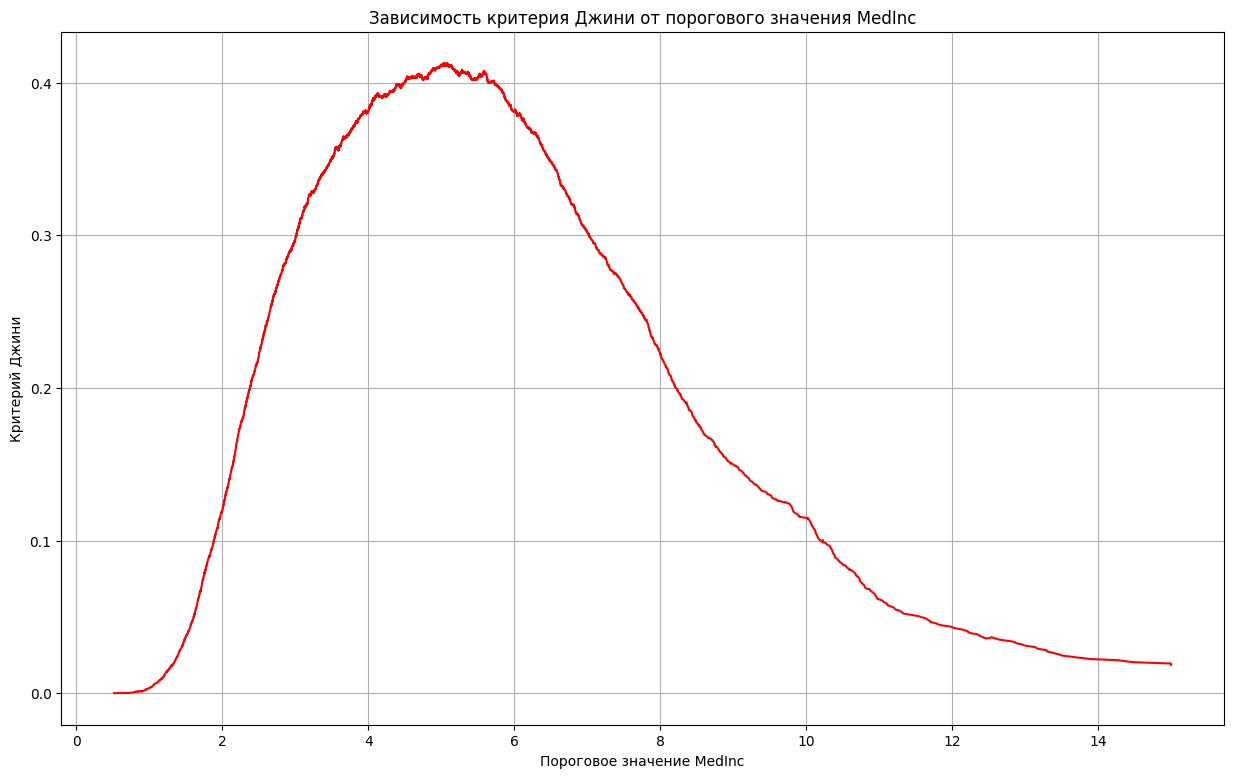

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(thrs, gns, color="r")
plt.title('Зависимость критерия Джини от порогового значения MedInc')
plt.xlabel('Пороговое значение MedInc')
plt.ylabel('Критерий Джини')
plt.grid(True)
plt.show()

In [ ]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            # print(gini)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        
        feature_index = node["feature_split"]
        
        if self._feature_types[feature_index] == "real":
            if x[feature_index] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_index] == "categorical":
            if x[feature_index] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError

    # Заполняем пропущенные значения средним значением(в случае вещественных признаков) или наиболее часто встречающися значением (в случае категориальных).
    def handle_missing_values(X: np.ndarray, feature_types: List[str]) -> np.ndarray:
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        X_filled = X.copy()
        for i, feature_type in enumerate(feature_types):
            if feature_type == "real":
                mean_value = np.nanmean(X[:, i])
                X_filled[:, i] = np.where(np.isnan(X[:, i]), mean_value, X[:, i])
            elif feature_type == "categorical":
                most_common = pd.Series(X[:, i]).mode().iloc[0]
                X_filled[:, i] = np.where(X[:, i] == '?', most_common, X[:, i])
        return X_filled

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = DecisionTree.handle_missing_values(X, self._feature_types)
        self._fit_node(X, y, self._tree)

    # для оценки важности признака используем сумму уменьшений критерия Джини при каждом разбиении, где использовался данный признак
    def _calculate_feature_importance(self, node: dict, importances: np.ndarray, total_samples: int) -> None:
        if node["type"] == "nonterminal":
            left_samples = node["left_child"]["samples"]
            right_samples = node["right_child"]["samples"]
            gini_reduction = node["gini"] - (left_samples / total_samples * node["left_child"]["gini"] + right_samples / total_samples * node["right_child"]["gini"])
            importances[node["feature_split"]] += gini_reduction * node["samples"]

            self._calculate_feature_importance(node["left_child"], importances, total_samples)
            self._calculate_feature_importance(node["right_child"], importances, total_samples)

    def feature_importances(self) -> np.ndarray:
        importances = np.zeros(len(self._feature_types))
        total_samples = self._tree["samples"]
        self._calculate_feature_importance(self._tree, importances, total_samples)
        return importances / total_samples

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

In [ ]:
data = pd.read_csv('students.csv')
features = ['STG', 'SCG', 'STR', 'LPR', 'PEG']
X = data[features]
y = data["UNS"]
X.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


STG: 0.031480529667148816
SCG: 0.020438106671071182
STR: 0.01811931025580421
LPR: 0.030789285418243273
PEG: 0.39939200196213387


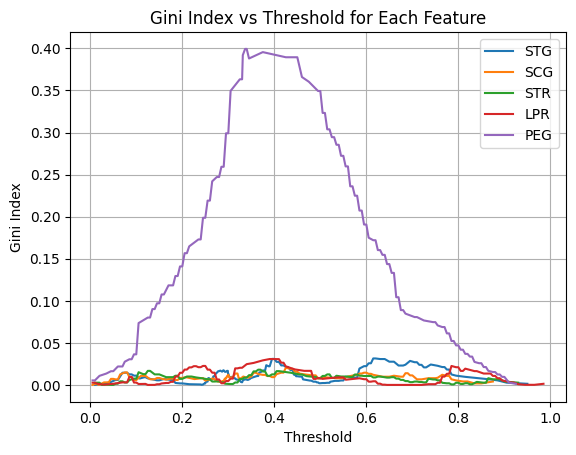

In [771]:
for i, feature in enumerate(features):
    thresholds, ginis, tbest, gbest = find_best_split(X[[feature]], y)
    print(f"{feature}: {gbest}")
    ts, inds = np.unique(thresholds, return_index=True)
    plt.plot(ts, ginis[inds], label=feature)

plt.xlabel('Threshold')
plt.ylabel('Gini Index')
plt.title('Gini Index vs Threshold for Each Feature')
plt.legend()
plt.grid(True)
plt.show()

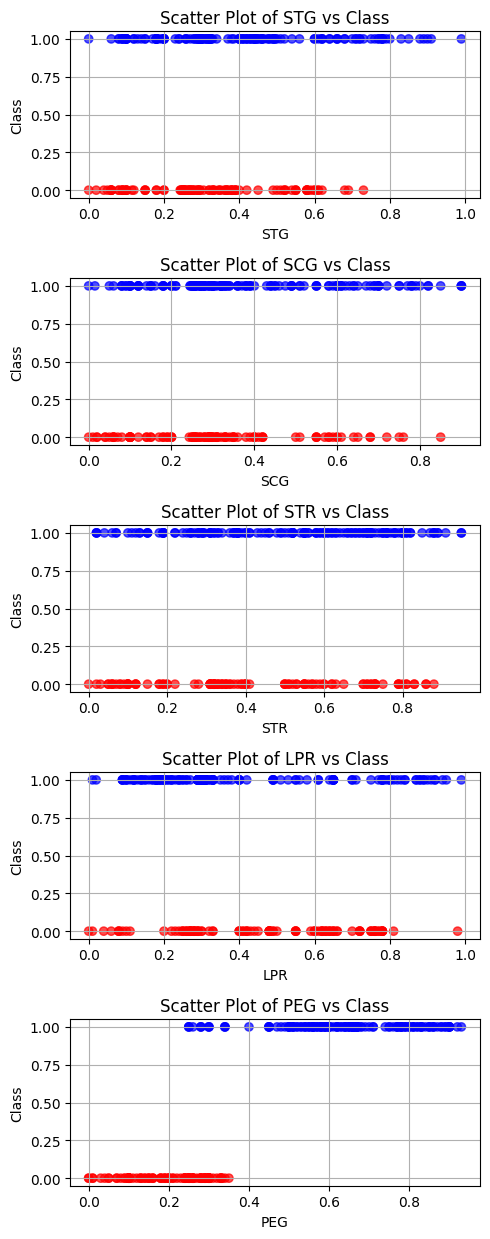

In [772]:
fig, axes = plt.subplots(5, 1, figsize=(5, 12.5))
for i, feature in enumerate(features):
    colors = ['red' if cls == 0 else 'blue' for cls in y]  # Определение цветов по классам
    axes[i].scatter(X[[feature]], y, alpha=0.7, c=colors)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Class')
    axes[i].set_title(f'Scatter Plot of {feature} vs Class')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [775]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in X.columns:
    le = LabelEncoder()
    X.loc[:, column] = le.fit_transform(X[column])
    label_encoders[column] = le
le = LabelEncoder()
label_encoders['poisonous'] = le
y.loc[:, 'poisonous'] = le.fit_transform(y['poisonous'])

In [776]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [777]:
types = ["categorical"] * X_train.shape[1]
clf = DecisionTree(types)

In [778]:
clf.fit(X_train, y_train.to_numpy())

In [ ]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_test.to_numpy())

if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()
    
y_test_pred = np.array(y_test_pred)

y_test = y_test.astype(np.int64)
y_test_pred = y_test_pred.astype(np.int64)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


## Бэггинг и случайный лес

In [780]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [781]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

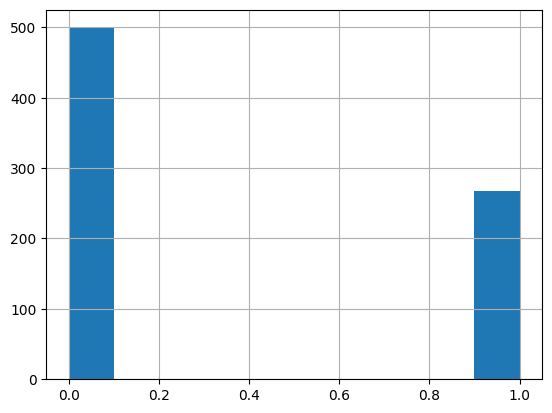

In [782]:
data['Outcome'].hist()
plt.show()

In [ ]:
X = data.iloc[:, :-1]  
y = data.iloc[:, -1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
max_depth_values = [3, 5, 7, 10, None]
min_samples_leaf_values = [1, 2, 4, 6, 8, 10]

best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train_train, y_train_train)
        y_val_pred = clf.predict(X_train_val)
        f1 = f1_score(y_train_val, y_val_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

print("Лучшие параметры:", best_params)
print("Лучшая f-мера:", best_f1)
best_clf = DecisionTreeClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)

y_test_pred = best_clf.predict(X_test)
y_test_pred_prob = best_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 6}
Лучшая f-мера: 0.6730769230769231
Accuracy: 0.7532
Precision: 0.6667
Recall: 0.5750
AUC-ROC: 0.7795


In [ ]:
bagging_clf = BaggingClassifier(
    n_estimators=50,
    random_state=42
)
bagging_clf.fit(X_train, y_train)

y_test_pred = bagging_clf.predict(X_test)
y_test_pred_prob = bagging_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.7489
Precision: 0.6310
Recall: 0.6625
AUC-ROC: 0.8083


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 15]
}

rf = RandomForestClassifier(n_estimators=50, random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

best_rf = RandomForestClassifier(n_estimators=50, **best_params, random_state=42)
best_rf.fit(X_train, y_train)

y_test_pred = best_rf.predict(X_test)
y_test_pred_prob = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Лучшие параметры: {'max_depth': 10, 'min_samples_split': 15}
Accuracy: 0.7532
Precision: 0.6456
Recall: 0.6375
AUC-ROC: 0.7960


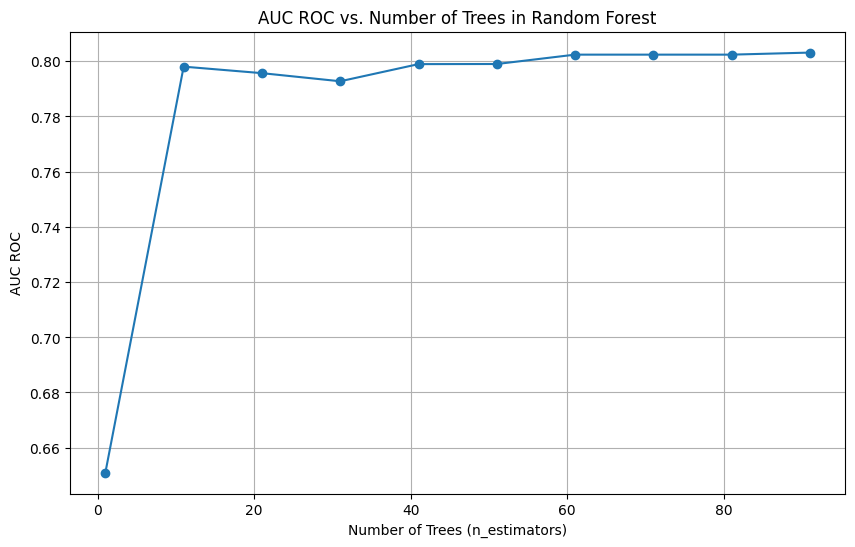

In [ ]:
n_estimators_range = range(1, 101, 10)

auc_roc_values = []

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_test_pred_prob = rf.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_test_pred_prob)
    auc_roc_values.append(auc_roc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_roc_values, marker='o', linestyle='-')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('AUC ROC')
plt.title('AUC ROC vs. Number of Trees in Random Forest')
plt.grid(True)
plt.show()

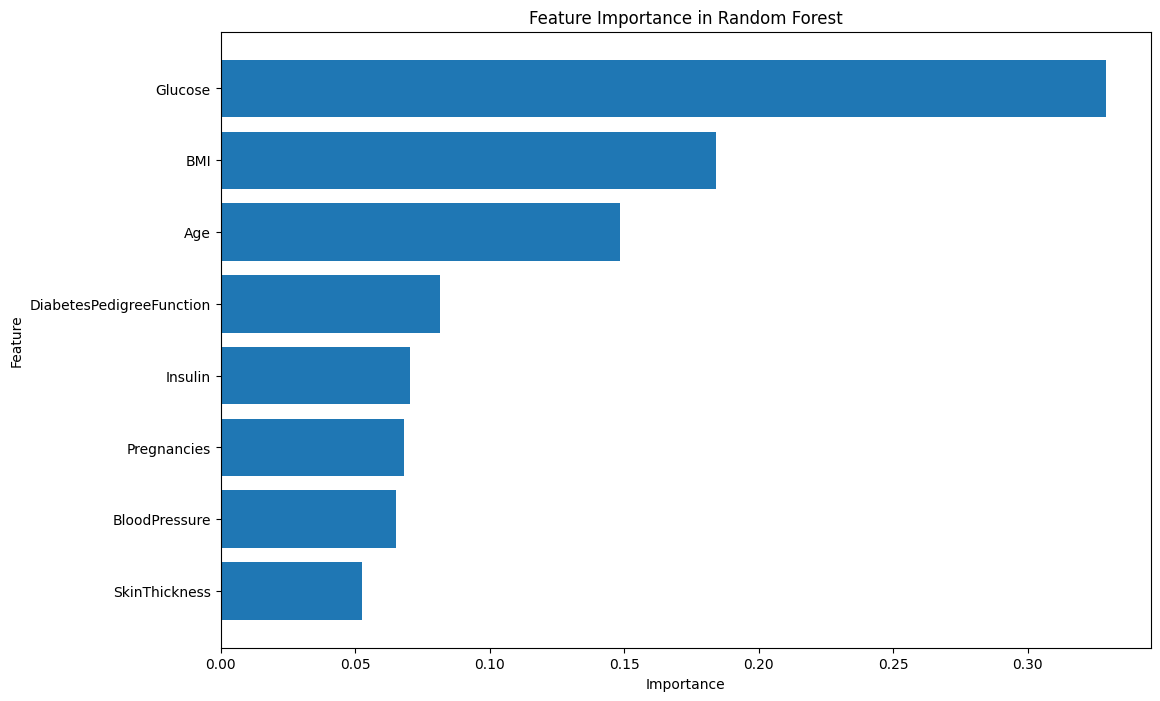

Самый важный признак: Glucose с важностью 0.3292


In [ ]:
feature_importances = best_rf.feature_importances_

feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

most_important_feature = feature_importance_df.iloc[0]
print(f"Самый важный признак: {most_important_feature['Feature']} с важностью {most_important_feature['Importance']:.4f}")

Это очевидно, т. к. суть заболевания именно в неконтролируемости уровне сахара в крови.